In [ ]:
%config InlineBackend.figure_format = 'retina'

In [77]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from kspecdr.inst.isoplane import convert_isoplane_header, add_fiber_table
from kspecdr.io.image import ImageFile
from kspecdr.preproc.make_im import make_im
from kspecdr.tlm.make_tlm import read_instrument_data

WD = Path("/data1/hbahk/kspec/kspecdr")
RESOURCES = WD / "resources"
TESTDIR = RESOURCES / "isoplane_arctest_20251224"

hdul = fits.open(TESTDIR / "flat_150_490_1sec 2025-12-24.fits")
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec 2025-12-24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     171   (1340, 1300, 5)   int16 (rescales to uint16)   


In [63]:
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "flat_150_490_1sec_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

In [64]:
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec 2025-12-24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     186   (1340, 1300)   uint16   
  1  FIBRES        1 BinTableHDU     13   16R x 2C   ['1A', '20A']   


In [66]:
from astropy.table import Table

Table(hdul[1].data)

TYPE,NAME
str1,str20
P,Fiber 1
P,Fiber 2
P,Fiber 3
P,Fiber 4
P,Fiber 5
P,Fiber 6
P,Fiber 7
P,Fiber 8
P,Fiber 9


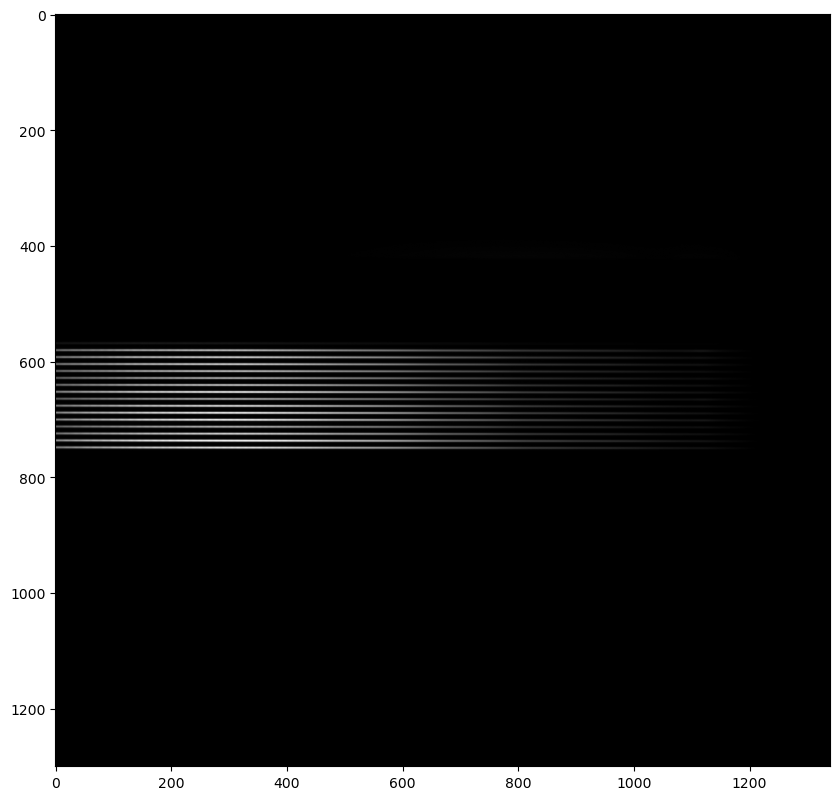

In [65]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(hdul[0].data, cmap="gray")
plt.show()

In [ ]:
args = {"IMAGE_FILENAME": new_fpath.as_posix()}

im = ImageFile(new_fpath.as_posix(), mode='READ')
im.open()


make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (

INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: UPDATE)
INFO:kspecdr.io.image:Copied fiber table 'FIBRES' from source file
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:0.01% of pixels were saturated
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_i

'/data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits'

In [80]:
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix()}

im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 6)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)


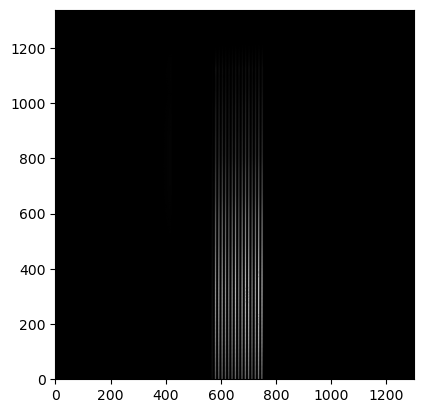

In [82]:
plt.imshow(img_data, cmap='gray', origin='lower')
plt.show()

In [ ]:
from pathlib import Path

WD = Path.cwd()
datadir = Path("/data1/hbahk/kspec/kspecdr/resources/")
# fpath = datadir / "08feb10087im.fits"
fpath = datadir / "08feb10093.fits"
args = {"IMAGE_FILENAME": fpath.as_posix()}

from kspecdr.io.image import ImageFile

im = ImageFile(fpath.as_posix(), mode='READ')
im.open()

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/08feb10093.fits (mode: READ)


In [70]:
Table(im.read_fiber_table())

NAME,RA,DEC,RA_DEG,DEC_DEG,RA_ACT,DEC_ACT,X,Y,ROTATION,XERR,YERR,TYPE,BUGID,BUGSRL,SUCCESS,PRIORITY,ASSIGNED,MAGNITUDE,COMMENT,PMRA_AS,PMDEC_AS,PROGRAM
str80,float64,float64,float64,float64,float64,float64,int32,int32,float64,int16,int16,str1,int32,int32,int16,int16,int16,float64,str80,float64,float64,str20
NO FIBRE IN THIS POSITION,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,N,0,0,0,0,0,0.0,,0.0,0.0,
NO FIBRE IN THIS POSITION,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,N,0,0,0,0,0,0.0,,0.0,0.0,
NO FIBRE IN THIS POSITION,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,N,0,0,0,0,0,0.0,,0.0,0.0,
NO FIBRE IN THIS POSITION,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,N,0,0,0,0,0,0.0,,0.0,0.0,
NO FIBRE IN THIS POSITION,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,N,0,0,0,0,0,0.0,,0.0,0.0,
AT NOMINAL HOME AFTER DEPLOY,0.0,0.0,0.0,0.0,0.0,0.0,-112600,-91800,0.0,0,0,P,18,264,0,0,0,0.0,,0.0,0.0,
AT NOMINAL HOME AFTER DEPLOY,0.0,0.0,0.0,0.0,0.0,0.0,-96200,-96200,0.0,0,0,P,19,113,0,0,0,0.0,,0.0,0.0,
AT NOMINAL HOME AFTER DEPLOY,0.0,0.0,0.0,0.0,0.0,0.0,-79700,-100600,0.0,0,0,P,20,418,0,0,0,0.0,,0.0,0.0,
AT NOMINAL HOME AFTER DEPLOY,0.0,0.0,0.0,0.0,0.0,0.0,-63300,-105000,0.0,0,0,P,21,224,0,0,0,0.0,,0.0,0.0,
